# 1. Library import

In [17]:
import os
import re
import cv2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# 2. Data Preprocessing

In [18]:
WORKING_DIR_PATH = '../input/hpa-single-cell-image-classification/'
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

In [19]:
df_train = pd.read_csv(WORKING_DIR_PATH + 'train.csv')
df_train['int_label'] = df_train['Label'].apply(lambda x: [int(element) for element in x.split('|')])
df_train['one_hot_label'] = df_train['int_label'].apply(lambda x: to_categorical(x, num_classes = 19))
df_train['one_hot_sum_label'] = df_train['one_hot_label'].apply(lambda x: sum(np.array(x)))
df_train

,ID,Label,int_label,one_hot_label,one_hot_sum_label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0,"[8, 5, 0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ..."
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,"[14, 0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,"[6, 1]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10,"[16, 10]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0,"[14, 0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
21801,dd0989c4-bbca-11e8-b2bc-ac1f6b6435d0,14,[14],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21802,dd1f7fb8-bbca-11e8-b2bc-ac1f6b6435d0,3|0,"[3, 0]","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21803,dd5cb36a-bbca-11e8-b2bc-ac1f6b6435d0,14|0,"[14, 0]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21804,df573730-bbca-11e8-b2bc-ac1f6b6435d0,14,[14],"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [20]:
def image_preprocessing(image_path):
    image = Image.open(image_path)
    image = np.array(image) / 255.0 # Normalize
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
    return image

# 3. Dataset Class

In [21]:
class HPA_dataset(nn.Module):
    
    def __init__(self, root_dir = '../input/hpa-single-cell-image-classification/train/',
                 ID = df_train['ID'],
                 label = df_train['one_hot_sum_label']):
        super().__init__()
        self.root_dir = root_dir
        self.ID = ID[:21000] # sample
        self.label = label[:21000]
    
    def __len__(self):
        return len(self.ID)
    
    def __getitem__(self, idx):
        png = self.ID[idx]
        one_hot_label = self.label[idx]
        
        # image path define
        image_R_path = self.root_dir + png + '_red.png'
        image_G_path = self.root_dir + png + '_green.png'
        image_B_path = self.root_dir + png + '_blue.png'
        image_Y_path = self.root_dir + png + '_yellow.png'
        
        # image preprocessing
        image_R = image_preprocessing(image_R_path)
        image_G = image_preprocessing(image_G_path)
        image_B = image_preprocessing(image_B_path)
        image_Y = image_preprocessing(image_Y_path)
        
        image_R = image_R.reshape(128, 128, 1)
        image_G = image_R.reshape(128, 128, 1)
        image_B = image_R.reshape(128, 128, 1)
        image_Y = image_R.reshape(128, 128, 1)
        
        # aggregate to one color file
        #color_image = np.stack((image_R, image_G, image_B))
        #print(color_image.shape)
        
        #color_image = color_image.reshape(image_R.shape[0], image_R.shape[0], -1)
        #print(color_image.shape)
                
        # labeling
        one_hot_label = np.array(one_hot_label)
        #print('label shape : {}'.format(one_hot_label.shape))
        return image_R, image_G, image_B, image_Y, one_hot_label
    
dataset = HPA_dataset()

# dataset and dataloader

In [22]:
train_dataset = HPA_dataset()
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True)

batch_image_R, batch_image_G, batch_image_B, batch_image_Y, batch_label = next(iter(train_loader))
print(batch_image_R.shape)
print(batch_image_G.shape)
print(batch_image_B.shape)
print(batch_image_Y.shape)
print(batch_label.shape)

torch.Size([1, 128, 128, 1])
torch.Size([1, 128, 128, 1])
torch.Size([1, 128, 128, 1])
torch.Size([1, 128, 128, 1])
torch.Size([1, 19])


# 4. Image visualization function for EDA

# 5. Modeling

In [23]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *
from tensorflow.keras.applications import *

In [24]:
base = EfficientNetB0(include_top = False,
                      weights = 'imagenet')
print(base)

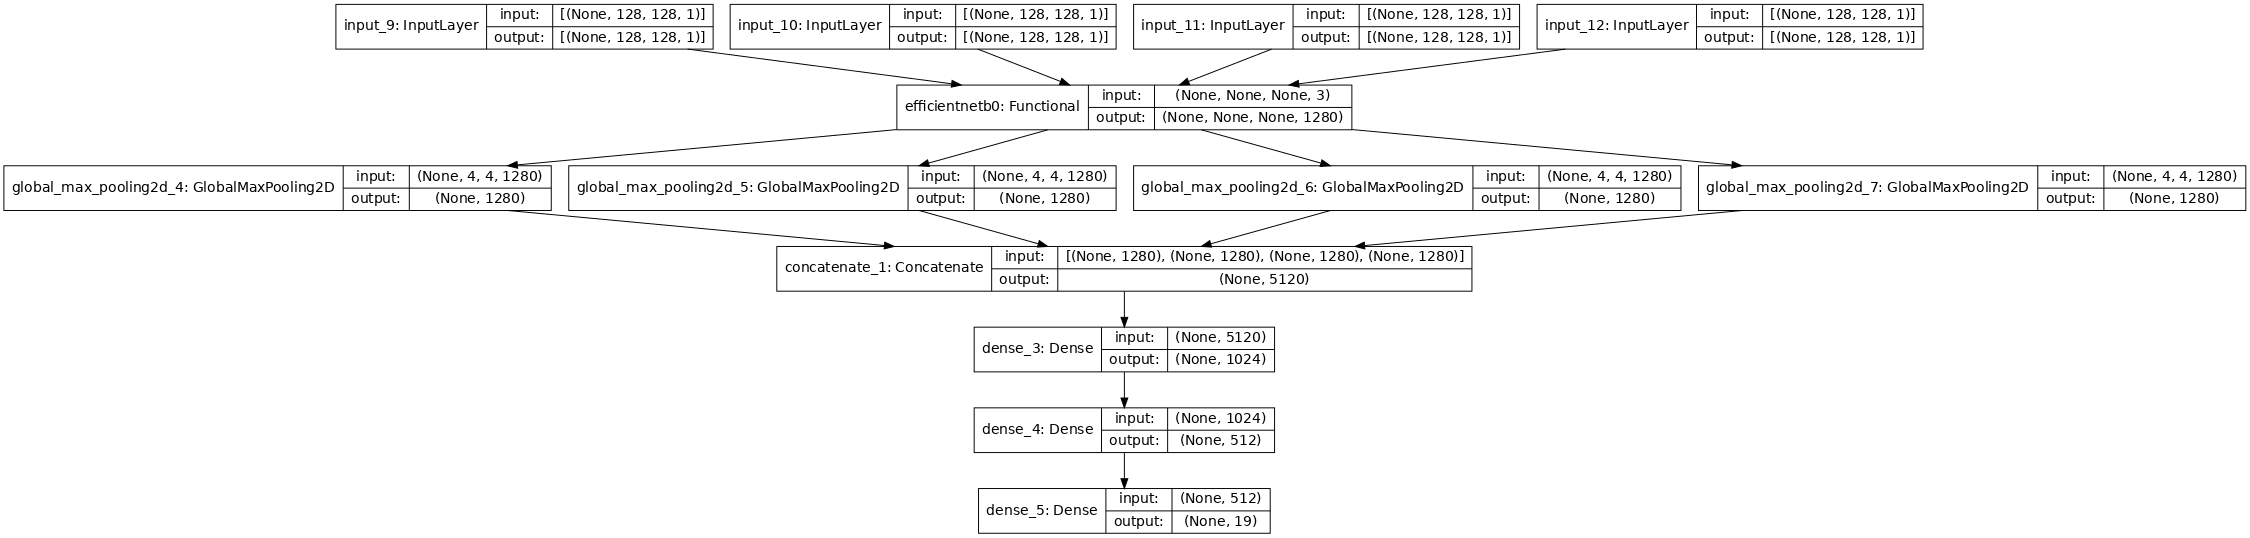

In [25]:
def build_model():
    base = EfficientNetB0(include_top = False,
                      weights = 'imagenet')
    
    Main_input_R = Input(shape = (128, 128, 1))
    Main_input_G = Input(shape = (128, 128, 1))
    Main_input_B = Input(shape = (128, 128, 1))
    Main_input_Y = Input(shape = (128, 128, 1))
    
    baseline_R = base(Main_input_R)
    baseline_G = base(Main_input_G)
    baseline_B = base(Main_input_B)
    baseline_Y = base(Main_input_Y)
    
    #reduced_R = Conv2D(320, kernel_size = 1, activation = 'relu')(baseline_R)
    #reduced_G = Conv2D(320, kernel_size = 1, activation = 'relu')(baseline_G)
    #reduced_B = Conv2D(320, kernel_size = 1, activation = 'relu')(baseline_B)
    #reduced_Y = Conv2D(320, kernel_size = 1, activation = 'relu')(baseline_Y)
    
    features_R = GlobalMaxPooling2D()(baseline_R) 
    features_G = GlobalMaxPooling2D()(baseline_G)
    features_B = GlobalMaxPooling2D()(baseline_B)
    features_Y = GlobalMaxPooling2D()(baseline_Y)
    
    union = concatenate([features_R, features_G, features_B, features_Y])
    
    output = Dense(1024, activation = 'relu')(union) # Convolution이 아니므로 he_normal 대신 glorot initialize
    output = Dense(512, activation = 'relu')(output)
    output = Dense(19, activation = 'sigmoid')(output)
    model = Model(inputs = [Main_input_R, Main_input_G, Main_input_B, Main_input_Y],
                outputs = output)
    return model

model = build_model()
plot_model(model, show_shapes = True, dpi = 70)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128, 128, 1) 0                                            
____________________________________________________________________________________________

In [27]:
model.compile(loss = 'binary_crossentropy', # 이진분류 손실함수
              optimizer = 'adam',
              metrics = ['accuracy'])

In [28]:
import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5),
    keras.callbacks.ModelCheckpoint(filepath = './Keras_Imageaug_Model.h5', # <---- 이 모델명으로 현재 디렉터리에 저장.
                                    monitor = 'val_loss', save_best_only = True),
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,
                                      patience = 3)]

In [29]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [30]:
hist_list = []

for num, (image_R, image_G, image_B, image_Y, label) in enumerate(train_loader):
    
    # 개별 데이터 1장씩 가져옴
    image_R = np.array(image_R)
    image_G = np.array(image_G)
    image_B = np.array(image_B)
    image_Y = np.array(image_Y)
    label = np.array(label)
    
    
    R, G, B, Y = [], [], [], []
    labels = []
    for _ in range(256):
        # 이에 대한 128개의 사본을 생성!
        vari_R = next(iter(datagen.flow(image_R)))
        vari_G = next(iter(datagen.flow(image_G)))
        vari_B = next(iter(datagen.flow(image_B)))
        vari_Y = next(iter(datagen.flow(image_Y)))
    
        R.append(vari_R)
        G.append(vari_G)
        B.append(vari_B)
        Y.append(vari_Y)
        labels.append(label)

        
    # 128개의 데이터 augmentation sample 생성하여 훈련데이터로 사용함
    R = np.array(R).reshape((-1, 128, 128, 1))
    G = np.array(G).reshape((-1, 128, 128, 1))
    B = np.array(B).reshape((-1, 128, 128, 1))
    Y = np.array(Y).reshape((-1, 128, 128, 1))
    labels = np.array(labels).reshape((-1, 19))

    
    hist = model.fit([R, G, B, Y], labels,
                    epochs = 8,
                    validation_split = 0.2,
                    batch_size = 64, 
                    verbose = 1)
    hist_list.append(hist)
    
    model.save('./HPA_keras_image_augmentation_model.h5')
    
    print('{}-th splited data training finished.'.format(num))

Epoch 1/8
4/4 [==============================] - 33s 2s/step - loss: 0.5251 - accuracy: 0.0000e+00 - val_loss: 1.3205e-13 - val_accuracy: 0.0000e+00
Epoch 2/8
4/4 [==============================] - 2s 444ms/step - loss: 4.2719e-38 - accuracy: 0.0000e+00 - val_loss: 4.9665e-07 - val_accuracy: 0.0000e+00
Epoch 3/8
4/4 [==============================] - 2s 450ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 4.2465e-13 - val_accuracy: 0.0000e+00
Epoch 4/8
4/4 [==============================] - 2s 449ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 4.6935e-22 - val_accuracy: 0.0000e+00
Epoch 5/8
4/4 [==============================] - 2s 444ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 7.5229e-31 - val_accuracy: 0.0000e+00
Epoch 6/8
4/4 [==============================] - 2s 458ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 3.2257e-36 - val_accuracy: 0.0000e+00
Epoch 7/8
4/4 [==============================] - 2s 453ms/step - loss: 0.000

KeyboardInterrupt: 

In [33]:
model.save('./HPA_keras_image_augmentation_model_.h5')

In [34]:
ls

HPA_keras_image_augmentation_model.h5       __notebook_source__.ipynb
HPA_keras_image_augmentation_model_1236.h5  model.png


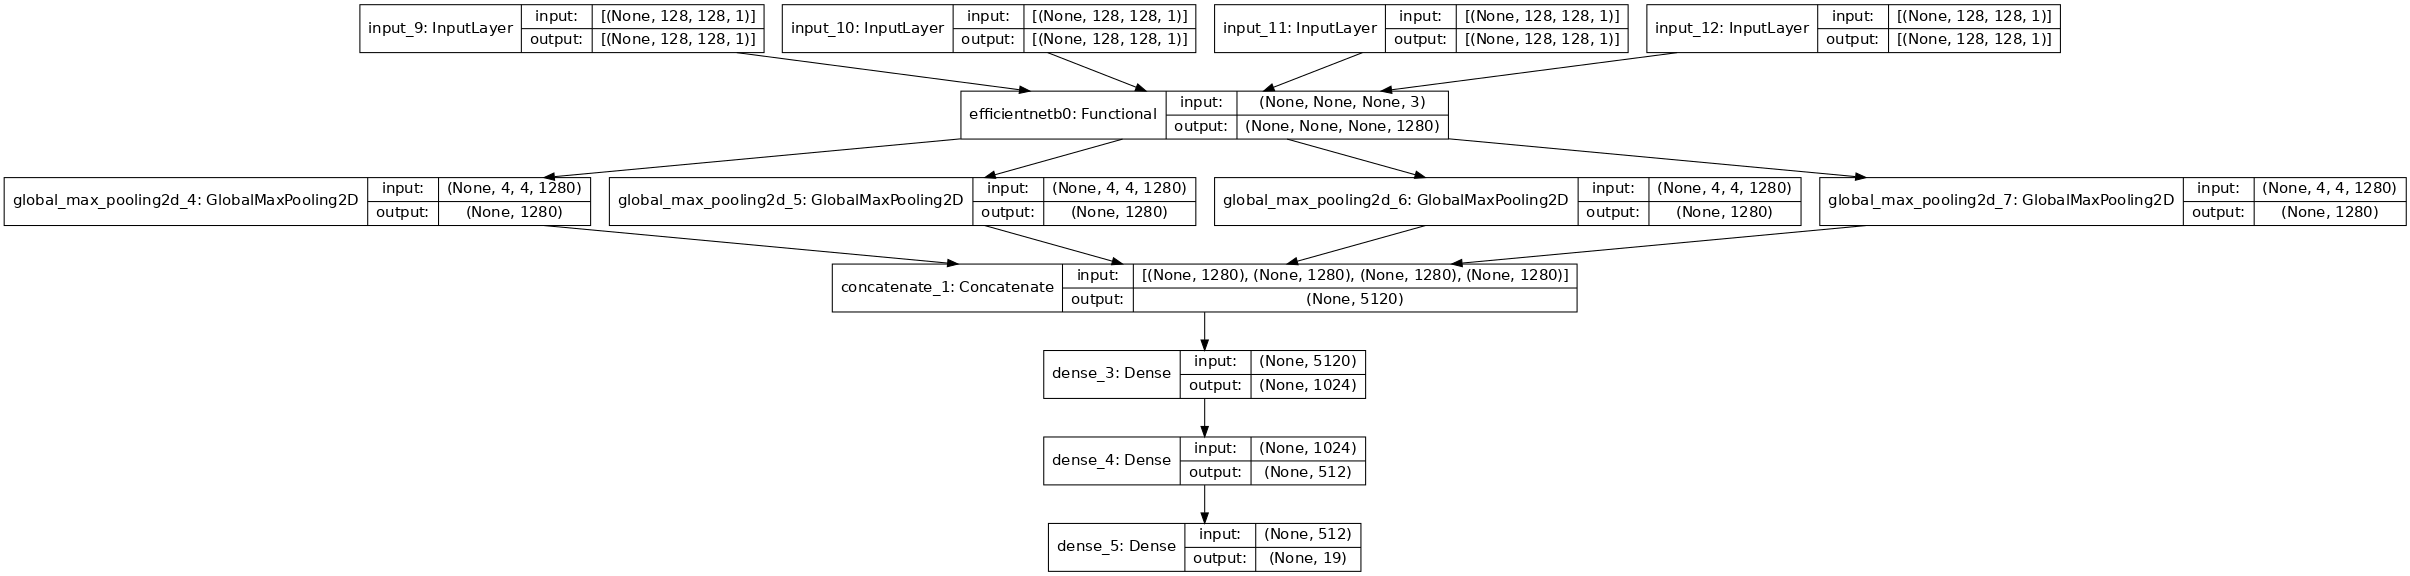

In [38]:
import keras
model = keras.models.load_model('HPA_keras_image_augmentation_model_1236.h5')
plot_model(model, show_shapes = True, dpi = 75)

In [39]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 128, 128, 1) 0                                            
____________________________________________________________________________________________

In [40]:
# measurement
losses = [hist_list[i].history['loss'] for i in range(len(hist_list))]
val_losses = [hist_list[i].history['val_loss'] for i in range(len(hist_list))] 
accuracy = [hist_list[i].history['accuracy'] for i in range(len(hist_list))]
val_accuracy = [hist_list[i].history['val_accuracy'] for i in range(len(hist_list))]


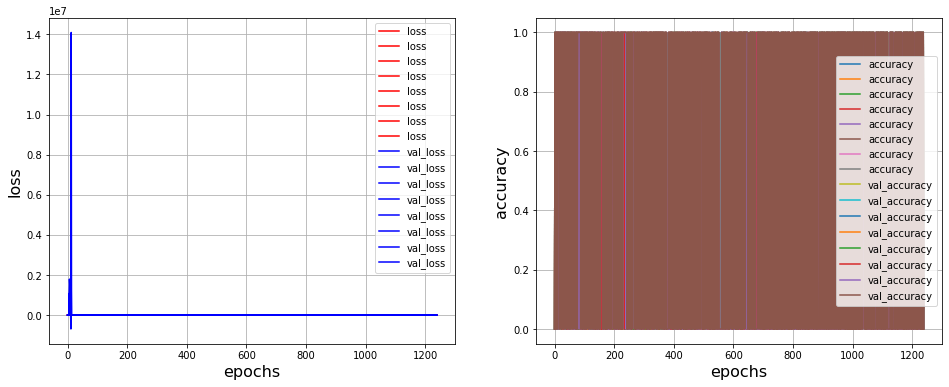

In [41]:
# plot measurement
plt.figure(figsize = (16, 6))
plt.subplot(121)
plt.plot(losses, label = 'loss', color = 'red')
plt.plot(val_losses, label = 'val_loss', color = 'blue')
#plt.plot(accuracy, label = 'accuracy')
#plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('epochs', size = 16)
plt.ylabel('loss', size = 16)
plt.grid(True)
plt.legend()

plt.subplot(122)
#plt.plot(losses, label = 'loss')
#plt.plot(val_losses, label = 'val_loss')
plt.plot(accuracy, label = 'accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('epochs', size = 16)
plt.ylabel('accuracy', size = 16)
plt.legend()
plt.grid(True)
plt.show()


# Test

In [46]:
class HPA_dataset_Test(nn.Module):
    
    def __init__(self, root_dir = '../input/hpa-single-cell-image-classification/train/',
                 ID = df_train['ID'],
                 label = df_train['one_hot_sum_label']):
        super().__init__()
        self.root_dir = root_dir
        self.ID = ID[21000:] # sample
        self.label = label[21000:]
    
    def __len__(self):
        return len(self.ID)
    
    def __getitem__(self, idx):
        png = self.ID[idx]
        one_hot_label = self.label[idx]
        
        # image path define
        image_R_path = self.root_dir + png + '_red.png'
        image_G_path = self.root_dir + png + '_green.png'
        image_B_path = self.root_dir + png + '_blue.png'
        image_Y_path = self.root_dir + png + '_yellow.png'
        
        # image preprocessing
        image_R = image_preprocessing(image_R_path)
        image_G = image_preprocessing(image_G_path)
        image_B = image_preprocessing(image_B_path)
        image_Y = image_preprocessing(image_Y_path)
        
        image_R = image_R.reshape(128, 128, 1)
        image_G = image_R.reshape(128, 128, 1)
        image_B = image_R.reshape(128, 128, 1)
        image_Y = image_R.reshape(128, 128, 1)
        
        # aggregate to one color file
        #color_image = np.stack((image_R, image_G, image_B))
        #print(color_image.shape)
        
        #color_image = color_image.reshape(image_R.shape[0], image_R.shape[0], -1)
        #print(color_image.shape)
                
        # labeling
        one_hot_label = np.array(one_hot_label)
        #print('label shape : {}'.format(one_hot_label.shape))
        return image_R, image_G, image_B, image_Y, one_hot_label
    
dataset = HPA_dataset()

In [50]:
test_dataset  = HPA_dataset()

test_loader  = DataLoader(test_dataset, batch_size = 32, shuffle = False)

test_R, test_G, test_B, test_Y, test_label = next(iter(test_loader))
test_R = np.array(test_R)
test_G = np.array(test_G)
test_B = np.array(test_B)
test_Y = np.array(test_Y)
test_label = np.array(test_label)

print(test_R.shape)
print(test_label.shape)

(32, 128, 128, 1)
(32, 19)


In [51]:
# 모델 성능 평가
score = model.evaluate([test_R, test_G, test_B, test_Y], test_label)
print(score)

1/1 [==============================] - 5s 5s/step - loss: 0.2566 - accuracy: 0.4062
[0.25664111971855164, 0.40625]


In [52]:
# 모델 예측
prediction = model.predict([test_R, test_G, test_B, test_Y])
print(prediction.shape)


(32, 19)


test sampel shape: (128, 128, 1)
test sampel shape: (128, 128, 1)
test sampel shape: (128, 128, 1)
test sampel shape: (128, 128, 1)
Predicted probability vector shape: (19,)
predicted probability of class: [4.3064049e-01 4.2773351e-02 9.7692698e-02 6.0358696e-02 5.4562699e-02
 8.4964074e-02 3.6817800e-02 7.9995841e-02 1.5860783e-02 6.9103785e-02
 3.6700647e-02 1.0426110e-03 8.8901930e-02 1.0119839e-01 8.2817458e-02
 2.7352688e-03 2.5721020e-01 2.8508743e-02 2.2687125e-05]


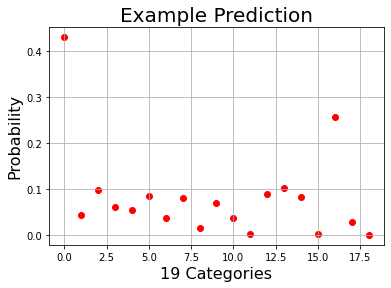

In [63]:
import random
r = random.randint(0, 32) # Random number 
sample_R, sample_G, sample_B, sample_Y, sample_label = test_R[r], test_G[r], test_B[r], test_Y[r], test_label[r] # Random sampling
print('test sampel shape: {}'.format(sample_R.shape))
print('test sampel shape: {}'.format(sample_G.shape))
print('test sampel shape: {}'.format(sample_B.shape))
print('test sampel shape: {}'.format(sample_Y.shape))

# prediction 
prob = model.predict([sample_R[np.newaxis, ...], sample_G[np.newaxis, ...], sample_B[np.newaxis, ...], sample_Y[np.newaxis, ...]]).reshape(-1)
print('Predicted probability vector shape: {}'.format(prob.shape))
print('predicted probability of class: {}'.format(prob))

# probability plot
plt.scatter(list(range(19)), prob, color = 'red')
plt.xlabel('19 Categories', size = 16)
plt.ylabel('Probability', size = 16)
plt.title('Example Prediction', size = 20)
plt.grid(True)
plt.show()


In [64]:
# Name Label Dictionary : 세포 생물학적 카테고리
classes = {
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles"   ,
5:  "Nuclear bodies"   ,
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus"   ,
8:  "Intermediate filaments",   
9:  "Actin filaments"   ,
10:  "Microtubules"   ,
11:  "Mitotic spindle"   ,
12:  "Centrosome" , 
13:  "Plasma membrane",   
14:  "Mitochondria"   ,
15:  "Aggresome"   ,
16:  "Cytosol",  
17:  "Vesicles and punctate cytosolic patterns",   
18:  "Negative" 
} 

In [67]:
print(prob)
refined_prob = np.where(prob >= 0.5)[0]
print(refined_prob)

answer = [classes[i] for i in refined_prob]
print('Predicted biological class: {}'.format(answer))
print('Target class : {}'.format(classes[np.argmax(sample_label)]))

[4.3064049e-01 4.2773351e-02 9.7692698e-02 6.0358696e-02 5.4562699e-02
 8.4964074e-02 3.6817800e-02 7.9995841e-02 1.5860783e-02 6.9103785e-02
 3.6700647e-02 1.0426110e-03 8.8901930e-02 1.0119839e-01 8.2817458e-02
 2.7352688e-03 2.5721020e-01 2.8508743e-02 2.2687125e-05]
[]
Predicted biological class: []
Target class : Mitochondria
